## Import libraries

In [34]:
# import libraries and modules
import chromdyn
from chromdyn import (
    ChromatinDynamics,
    TopologyGenerator,
    HiCManager, save_pdb,
    PlatformManager,
    Analyzer,
    TrajectoryLoader,
)
import pandas as pd
print('Loaded chromdyn version: ' + chromdyn.__version__ )
# to inspect the location of chromdyn on the filesystem, uncomment the lines below
# import inspect, os
# print('chromdyn located at:', os.path.dirname(inspect.getfile(chromdyn)))

Loaded chromdyn version: 0.1.1


## Step 1: Generate topology
A topology object needs to be created that holds the monomer identities and their connectivity, which is passed to the simulation

- Initialize topology generator object: `topo = TopologyGenerator()`

- Generate topology: `topo.gen_top(chain_lens=[N, M], chain_names=["chr1", "chr2"], isRing=[0,1], types='A')`

    - Default topology for a chain of size N: `topo.gen_top([N])` or `topo.gen_top([N, M])` for topology of two chains of sizes N and M

    - Specifying chain names: `chain_names=["chr1", "chr2"])`

    - Specifying ring topologies, the above code makes `chr1` a linear and `chr2` a circular chain

    - Specifying monomer types
        - string: `types=A`, all monomer types are labeled by the string
        - list: `types=['A']*n + ['B']*m`, the first `n` monomers are labeled `A` and next `m` monomers are labeled `B`--ensure `N+M=n+m`
        - keyword: `types='unique'`, all monomers are uniquely labeled as `M1, M2, M3 ...`
        - file: `types=sequence.txt`, the first coloumn should be the monomer index and second column the label--all monomers are labeled accrdingly
    
- The topology object can be accessed via `topo.topology` and the sequence of types is stored in `topo.atom_types`
- The topology can be printed on the console using `topo.print_top` and saved in a file using `topo.save_top('filename.txt')`

## Step 2: Initialize simulation object
The simulator object `ChromatinDynamics` needs to be initialized with 
- `topology` (required)
- `name: str` = "ChromatinDynamics" (this name will be used for log files)
- `platform_name: str` = "CUDA" (check available platforms using `PlatformManager` or by running on the terminal: `python -m chromdyn.check_install`)
- `output_dir: str` = "output" (if the directory does not exist it will be created)
- `console_stream: bool` = True (choose to output on the terminal)
- `write_logs: bool` = True (whether log files will be created, output_dir is created only when this is True)

## Step 3: Add forces
Forces are handled by `force_field_manager`-- typical forces that can be added are harmonic bonds, soft-core self avoidance, confinements, COM remover, etc.

## Step 4: Setup simulations
This is where the simulation context is generated. 
- The setup can take the following arguments:
    - init_struct: Union[str, NDArray] = "randomwalk" (one may also specify "random"--a random gas; 'saw3d', and a (N,3) np.array specifying positions )
    - integrator: str = "langevin" (other options are "brownian", "active-langevin", and "active-brownian")
    - temperature: float = 120.0
    - timestep: float = 0.01 
    - friction: float = 0.1 
    - save_pos: bool = True (whether positions are saved into a file or not, if True needs write_logs=True)
    - save_energy: bool = True  (whether energies are saved into a file or not, if True needs write_logs=True)
    - stability_check: bool = True (whether to check for stability and reinitialize the velocites when the KE or PE explode)
    - stability_report_interval: int = 500 
    - energy_report_interval: int = 1000
    - pos_report_interval: int = 1000

- Upon setting up the output (console or log) shows the energies in the system from the initial structure
- The files corresponding to positions (_positions.cndb) and energies (_energy_report.txt) are generated and the terminal output gives the filenames
- The stability file will be generated and will be populated only if stability issues arise and velocity reinitialization is implemented

## Step 5: Run simulation and save data
- The simulation after setup can be run for any number of integer steps using `sim.run(n_steps, report=True)`
- The `report` flag is used to detrmine if the positions and/or energies from this run are saved or not, e.g., for equiliibration runs one should set it to `False`
- At any point a summary of energies/forces in the system can be accessed via `sim.print_force_info()`
- Additionally, a snapshot maybe saved as a pdb for visualization using `save_pdb(sim)`; the filename is autogenerated from the step number
- Finally, the reports must be saved using `sim.save_reports()`; ofcourse, this is not required if `write_logs=False`

## Step 6: Analyze simulated trajectory
- The simulated trajectory can be loaded from the positions.cndb file using `TrajectoryLoader`
- analyses like radius of gyration can be computed
- Hi-C contact maps can be generated using `HiCManager`


In [2]:
# Step 1: topology
topo = TopologyGenerator()
topo.gen_top([100, 50])

In [3]:
# Step 2a: get platforms 
pm = PlatformManager()
pm.list_platforms()

2025-12-11 03:10:29,968 | INFO | platforms | --------------------------------------------------
2025-12-11 03:10:29,969 | INFO | platforms | Number of available OpenMM platforms: 3
2025-12-11 03:10:29,969 | INFO | platforms | Index    Platform Name        Speed (estimated)   
2025-12-11 03:10:29,970 | INFO | platforms | --------------------------------------------------
2025-12-11 03:10:29,971 | INFO | platforms | 0        Reference            1.0                 
2025-12-11 03:10:29,972 | INFO | platforms | 1        CPU                  10.0                
2025-12-11 03:10:29,972 | INFO | platforms | 2        OpenCL               50.0                
2025-12-11 03:10:29,973 | INFO | platforms | --------------------------------------------------


In [4]:
# Step 2b: initialize simulation
sim = ChromatinDynamics(topo.topology, name = 'test', platform_name = "CPU", output_dir = "output", console_stream = True)

# Step 3: add forces
sim.force_field_manager.add_harmonic_bonds()
sim.force_field_manager.add_self_avoidance()
sim.force_field_manager.add_flat_bottom_harmonic()


2025-12-11 03:10:31,767 | INFO | chromatin_dynamics | ************************************************************
2025-12-11 03:10:31,767 | INFO | chromatin_dynamics |             chromdyn v0.1.1 : Chromatin Dynamics            
2025-12-11 03:10:31,768 | INFO | chromatin_dynamics | ************************************************************
2025-12-11 03:10:31,769 | INFO | chromatin_dynamics | System initialized with 150 particles. Output directory: output
2025-12-11 03:10:31,769 | INFO | platforms | Platform 'CPU' is available and selected.
2025-12-11 03:10:31,769 | INFO | chromatin_dynamics | force_field_manager initialized. Use this to add forces before running setup.
2025-12-11 03:10:31,770 | INFO | forcefield | Adding 148 harmonic bonds with r0=1.0, k=10.0, group=0
2025-12-11 03:10:31,770 | INFO | forcefield | HarmonicBonds force successfully added to system.
2025-12-11 03:10:31,771 | INFO | forcefield | --------------------------------------------------
2025-12-11 03:10:31,771 

In [5]:
# Step 4: set up simulation
sim.simulation_setup(
            init_struct='randomwalk',
            integrator='langevin',
            temperature=120.0,
            timestep=0.01,
            save_pos=True,
            save_energy=True,              
            )

2025-12-11 03:10:33,020 | INFO | integrators | Creating integrator ...
2025-12-11 03:10:33,021 | INFO | integrators | LangevinIntegrator: temperature=120.0 | friction=0.1 | timestep=0.01
2025-12-11 03:10:33,028 | INFO | chromatin_dynamics | Setting up simulation context...
2025-12-11 03:10:33,028 | INFO | chromatin_dynamics | Random walk created. Position shape: (150, 3)
2025-12-11 03:10:33,029 | INFO | chromatin_dynamics | Simulation context initialized.
2025-12-11 03:10:33,029 | INFO | chromatin_dynamics | ------------------------------------------------------------------------------------------------------------------------
2025-12-11 03:10:33,029 | INFO | chromatin_dynamics | Index  Force Class                    Force Name           Group    Particles    Bonds        Exclusions   P.E./Particle       
2025-12-11 03:10:33,030 | INFO | chromatin_dynamics | ------------------------------------------------------------------------------------------------------------------------
2025-12-

In [6]:
# Step 5: run simulation

# equilibration
sim.run(5_000, report=False)

#check forces
sim.print_force_info()

# production
sim.run(20_000, report=True)

# save pdbs of individual configs
save_pdb(sim)

sim.print_force_info()

#Simulations done -- save reports
sim.save_reports()

2025-12-11 03:10:35,965 | INFO | chromatin_dynamics | ------------------------------------------------------------
2025-12-11 03:10:35,965 | INFO | chromatin_dynamics | Running simulation for 5000 steps...
2025-12-11 03:10:35,966 | INFO | chromatin_dynamics | Paused reporter: position
2025-12-11 03:10:35,966 | INFO | chromatin_dynamics | Paused reporter: energy
2025-12-11 03:10:38,147 | INFO | chromatin_dynamics | Completed 5000 steps in 2.18s (2294 steps/s)
2025-12-11 03:10:38,147 | INFO | chromatin_dynamics | ------------------------------------------------------------
2025-12-11 03:10:38,147 | INFO | chromatin_dynamics | Resumed reporter: position
2025-12-11 03:10:38,148 | INFO | chromatin_dynamics | Resumed reporter: energy
2025-12-11 03:10:38,148 | INFO | chromatin_dynamics | ------------------------------------------------------------------------------------------------------------------------
2025-12-11 03:10:38,148 | INFO | chromatin_dynamics | Index  Force Class               

In [25]:
# Step 6a: Analysis
# you may also specify directly the position file
traj_file = sim.reporters.get('position').filename

print(f'Trajectory file: { traj_file }')

# position analysis
xyz = TrajectoryLoader.load(traj_file)
print(f'Loaded trajectory with shape: { xyz.shape }')
print(f'Radius of gyration: { Analyzer.compute_RG(xyz).mean() }')


Trajectory file: output/test_positions.cndb
Loaded trajectory with shape: (20, 150, 3)
Radius of gyration: 7.364877787636715


Trajectory file: output/test_positions.cndb | Energy file: output/test_energy_report.txt
Mean energy per particle for HarmonicBonds(0): 0.66708
Mean energy per particle for SelfAvoidance(2): 0.08161
Mean energy per particle for FlatBottomHarmonic(1): 0.00764


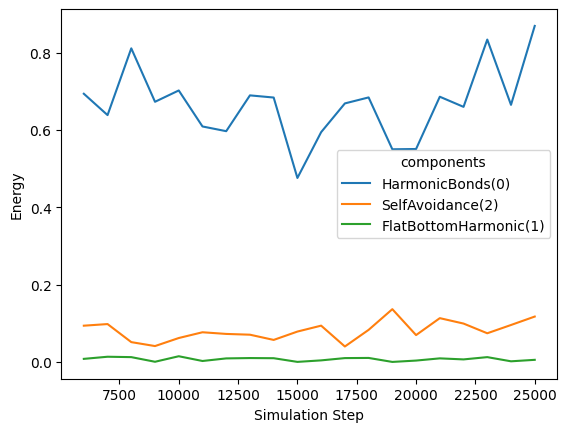

In [31]:
# install matplotlib if you don't have it: pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

energy_file = sim.reporters.get('energy').filename
print(f'Trajectory file: { traj_file } | Energy file: { energy_file }')

energies = pd.read_csv(energy_file,sep=r"\s+", engine="python")

# energy components
energy_comps= energies.keys().tolist()[5:]  # exclude time column

for comp in energy_comps:
    mean_energy = energies[comp].mean()
    # the term in parenthesis are force groups
    print(f'Mean energy per particle for {comp}: {mean_energy:.5f}')
    plt.plot(energies['Step'], energies[comp], label=f'{comp}')

plt.ylabel("Energy")
plt.xlabel("Simulation Step")
plt.legend(title="components")

2025-12-11 03:19:52,778 | INFO | hic_utils | Loading trajectory ...
2025-12-11 03:19:52,782 | INFO | hic_utils | Trajectory shape: (20, 150, 3)
2025-12-11 03:19:52,783 | INFO | hic_utils | Using multiprocessing. Dividing into 3 processes.
2025-12-11 03:19:54,089 | INFO | hic_utils | Generated HiC matrix of shape: (150, 150)


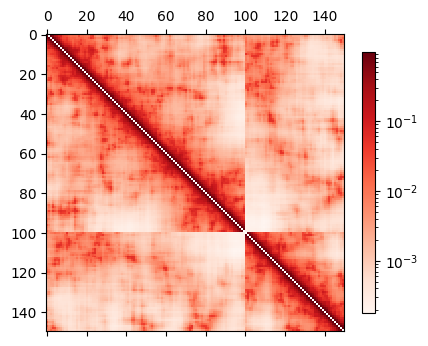

In [32]:
# Step 6b: Generate HiC map
hicman = HiCManager()
#Generating HiC from traj
hic = hicman.gen_hic_from_cndb(traj_file=traj_file, mu=2.0, rc=2.0, p=4.0, parallel=True)
plt.matshow(hic, cmap='Reds', norm=LogNorm())
plt.colorbar(shrink=0.7)